<a href="https://colab.research.google.com/github/arthuremanuel/Artificial_Intelligence_Classes/blob/main/Disaster_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
* The core challenge of this competition is a text classification task.
* Given the text of a tweet, the goal is to predict whether it is about a real disaster (target = 1) or not (target = 0).
* This is a classic binary classification problem within the field of Natural Language Processing (NLP).

**Dataset**

* Training Data (train.csv): Contains 7,613 tweets. Each row has the following columns: id, keyword, location, text (the tweet itself), and target (the label we want to predict).

* Test Data (test.csv): Contains 3,263 tweets. It has the same columns as the training data, except for the target column.

In [1]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Exploratory Data Analysis

In [2]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

print("\nTraining Data Head:")
print(train_df.head())

Training Data Shape: (7613, 5)
Test Data Shape: (3263, 4)

Training Data Head:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


/tmp/ipython-input-3872017840.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=train_df, palette=['#3498db', '#e74c3c'])


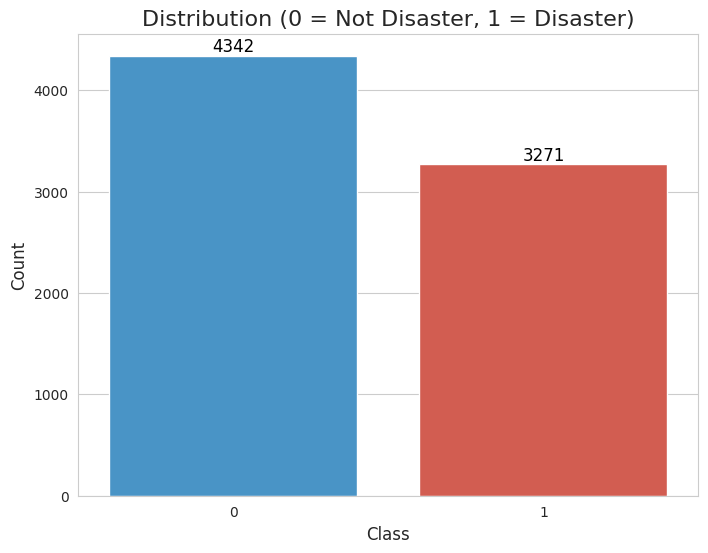

In [12]:
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

sns.set_style('whitegrid')

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df, palette=['#3498db', '#e74c3c'])

plt.title('Distribution (0 = Not Disaster, 1 = Disaster)', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), f'{int(p.get_height())}',
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()

In [3]:
# Initialize the lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)
print("Cleaning training data...")
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
print("Cleaning test data...")
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

print("\nSample of cleaned text:")
print(train_df[['text', 'cleaned_text']].head())

Cleaning training data...
Cleaning test data...

Sample of cleaned text:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  13000 people receive wildfire evacuation order...  
4  got sent photo ruby alaska smoke wildfire pour...  


In [4]:
# --- Tokenization ---
vocab_size = 10000
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_df['cleaned_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

seq_lengths = [len(s) for s in train_sequences]
max_length = int(np.percentile(seq_lengths, 95))
print(f"\nSetting max sequence length to: {max_length}")

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

y = train_df['target'].values

print("Shape of padded training data:", train_padded.shape)
print("Shape of target data:", y.shape)


Setting max sequence length to: 15
Shape of padded training data: (7613, 15)
Shape of target data: (7613,)


In [6]:
# --- Load GloVe embeddings ---
embedding_dim = 100
glove_file = 'glove.6B.100d.txt'

print(f"\nLoading GloVe embeddings from {glove_file}...")
embeddings_index = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

# --- Create embedding matrix ---
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

print("Shape of embedding matrix:", embedding_matrix.shape)


Loading GloVe embeddings from glove.6B.100d.txt...
Found 11008 word vectors.
Shape of embedding matrix: (10000, 100)


# Model Architecture
* Word Representation: GloVe (Global Vectors for Word Representation): This is a pre-trained word embedding.
* RNN: Long Short-Term Memory (LSTM) network, which is a special type of RNN.

In [7]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=False),

    Bidirectional(LSTM(64, return_sequences=True)),

    GlobalMaxPooling1D(),

    Dense(32, activation='relu'),

    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_padded, y, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7108 - loss: 0.5844 - val_accuracy: 0.7971 - val_loss: 0.4695 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7945 - loss: 0.4587 - val_accuracy: 0.7965 - val_loss: 0.4628 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8000 - loss: 0.4396 - val_accuracy: 0.7978 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8185 - loss: 0.4082 - val_accuracy: 0.7997 - val_loss: 0.4567 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8438 - loss: 0.3708 - val_accuracy: 0.7997 - val_loss: 0.4626 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8494 - loss: 0.3583 - val_accuracy: 0.7525 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8667 - loss: 0

# Results and Analysis

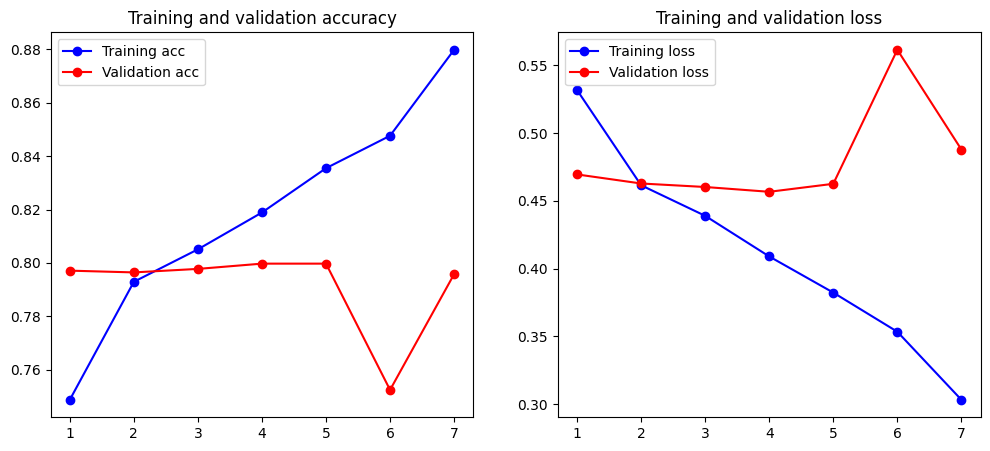

In [10]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# Conclusion
* The most significant takeaway is that feature engineering and preprocessing remain critical, even with advanced models.
* The experiment confirmed the power of transfer learning in NLP. The use of pre-trained GloVe embeddings provided a massive performance boost.


# Submission File

In [9]:
# Make predictions on the test data
test_predictions = model.predict(test_padded)

# Convert probabilities to binary predictions (0 or 1)
test_predictions = (test_predictions > 0.5).astype(int).flatten()

# Create the submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file created successfully!")
print(submission_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Submission file created successfully!
   id  target
0   0       1
1   2       1
2   3       1
3   9       0
4  11       1
